In [1]:
# import os
# import kagglehub

# data = kagglehub.dataset_download('kritanjalijain/amazon-reviews')

# # Get the path where the dataset is saved
# dataset_path = os.path.dirname(data)

# print(f"The dataset is saved at: {dataset_path}")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import ssl
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
import joblib
from collections import Counter
import time
import pandas as pd
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [3]:
# For displaying options
pd.set_option('display.max_colwidth', 300)
pd.set_option('display.max_rows', 100)

In [4]:
train_df = pd.read_csv("./data/train.csv")

print("----- Train Dataset -----")
display(train_df.head())

----- Train Dataset -----


,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^
0,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fa...
1,2,Amazing!,"This soundtrack is my favorite music of all time, hands down. The intense sadness of ""Prisoners of Fate"" (which means all the more if you've played the game) and the hope in ""A Distant Promise"" and ""Girl who Stole the Star"" have been an important inspiration to me personally throughout my teen y..."
2,2,Excellent Soundtrack,"I truly like this soundtrack and I enjoy video game music. I have played this game and most of the music on here I enjoy and it's truly relaxing and peaceful.On disk one. my favorites are Scars Of Time, Between Life and Death, Forest Of Illusion, Fortress of Ancient Dragons, Lost Fragment, and D..."
3,2,"Remember, Pull Your Jaw Off The Floor After Hearing it","If you've played the game, you know how divine the music is! Every single song tells a story of the game, it's that good! The greatest songs are without a doubt, Chrono Cross: Time's Scar, Magical Dreamers: The Wind, The Stars, and the Sea and Radical Dreamers: Unstolen Jewel. (Translation varie..."
4,2,an absolute masterpiece,"I am quite sure any of you actually taking the time to read this have played the game at least once, and heard at least a few of the tracks here. And whether you were aware of it or not, Mitsuda's music contributed greatly to the mood of every single minute of the whole game.Composed of 3 CDs an..."


In [5]:
test_df = pd.read_csv("./data/test.csv")

print("----- Test Dataset -----")
display(test_df.head())

----- Test Dataset -----


,2,Great CD,"My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I'm in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life's hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing ""Who was that singing ?"""
0,2,One of the best game music soundtracks - for a game I didn't really play,"Despite the fact that I have only played a small portion of the game, the music I heard (plus the connection to Chrono Trigger which was great as well) led me to purchase the soundtrack, and it remains one of my favorite albums. There is an incredible mix of fun, epic, and emotional songs. Those..."
1,1,Batteries died within a year ...,"I bought this charger in Jul 2003 and it worked OK for a while. The design is nice and convenient. However, after about a year, the batteries would not hold a charge. Might as well just get alkaline disposables, or look elsewhere for a charger that comes with batteries that have better staying p..."
2,2,"works fine, but Maha Energy is better","Check out Maha Energy's website. Their Powerex MH-C204F charger works in 100 minutes for rapid charge, with option for slower charge (better for batteries). And they have 2200 mAh batteries."
3,2,Great for the non-audiophile,"Reviewed quite a bit of the combo players and was hesitant due to unfavorable reviews and size of machines. I am weaning off my VHS collection, but don't want to replace them with DVD's. This unit is well built, easy to setup and resolution and special effects (no progressive scan for HDTV owner..."
4,1,DVD Player crapped out after one year,"I also began having the incorrect disc problems that I've read about on here. The VCR still works, but hte DVD side is useless. I understand that DVD players sometimes just quit on you, but after not even one year? To me that's a sign on bad quality. I'm giving up JVC after this as well. I'm sti..."


In [6]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

print("Train columns:", list(train_df.columns))
print("Test columns:", list(test_df.columns))

Train shape: (3599999, 3)
Test shape: (399999, 3)
Train columns: ['2', 'Stuning even for the non-gamer', 'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^']
Test columns: ['2', 'Great CD', 'My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I\'m in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life\'s hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, m

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3599999 entries, 0 to 3599998
Data columns (total 3 columns):
 #   Column                                                                                                                                                                                                                                                                                                                                                                                                      Dtype 
---  ------                                                                                                                                                                                                                                                                                                                                                                                                      ----- 
 0   2                                                                  

In [8]:
# Fix column names
train_df.columns = ['score', 'summary', 'text']
test_df.columns = ['score', 'summary', 'text']

# Check first 5 rows after renaming
display(train_df.head())

# Check missing values
print("\nMissing values per column:")
print(train_df.isnull().sum())

,score,summary,text
0,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fa...
1,2,Amazing!,"This soundtrack is my favorite music of all time, hands down. The intense sadness of ""Prisoners of Fate"" (which means all the more if you've played the game) and the hope in ""A Distant Promise"" and ""Girl who Stole the Star"" have been an important inspiration to me personally throughout my teen y..."
2,2,Excellent Soundtrack,"I truly like this soundtrack and I enjoy video game music. I have played this game and most of the music on here I enjoy and it's truly relaxing and peaceful.On disk one. my favorites are Scars Of Time, Between Life and Death, Forest Of Illusion, Fortress of Ancient Dragons, Lost Fragment, and D..."
3,2,"Remember, Pull Your Jaw Off The Floor After Hearing it","If you've played the game, you know how divine the music is! Every single song tells a story of the game, it's that good! The greatest songs are without a doubt, Chrono Cross: Time's Scar, Magical Dreamers: The Wind, The Stars, and the Sea and Radical Dreamers: Unstolen Jewel. (Translation varie..."
4,2,an absolute masterpiece,"I am quite sure any of you actually taking the time to read this have played the game at least once, and heard at least a few of the tracks here. And whether you were aware of it or not, Mitsuda's music contributed greatly to the mood of every single minute of the whole game.Composed of 3 CDs an..."



Missing values per column:
score       0
summary    77
text        0
dtype: int64


In [9]:
test_df.sample(5)

,score,summary,text
67891,1,"Great idea, but...","I bought this set for my shop sink. I'm there 3 or 4 times a week so the idea that it shuts off the water with excessive flow caught my attention. When installing, the nut connecting the new line to the water valve leaked, as I tightened it up the nut separated from the rest of the new line and ..."
117121,1,A dud?,"I bought this to use at my school. It's barely been used and never been abused but discs will not play and the volume often does not work. There seems to be a short in it as occasionally I use it as speakers for a computer (line-in capability) since the discs won't play, but often I can't get an..."
370582,2,The Original Beck,"If you want to read about drugs, groupies and gossip, don't buy this book. Although Jeff Beck has influenced countless guitarists for the last 40 years, the average person doesn't recognize his name. He always preferred to restore his collection of antique cars, instead of recording new albums o..."
159574,1,Did not fit correctly with wire harness connector.,Slight difference on connector between this and original. Because of this the harness fit fine but could not securely clip in place. My car is a 99 honda civic ex.
148738,2,"great watch, but how do you adjust the band?","I'm very pleased with this wristwatch. Accurate time, day, date and alarm are all I want, and this watch provides it all, with easy to read numbers. The only thing I haven't figured out is how to adjust the metallic strap. Any help out there?"


In [10]:
# Map polarity to sentiment
train_df['sentiment'] = train_df['score'].map({1:'negative', 2:'positive'})
test_df['sentiment'] = test_df['score'].map({1:'negative', 2:'positive'})

# Check distribution
print("Train sentiment distribution:\n", train_df['sentiment'].value_counts())
print("\nTest sentiment distribution:\n", test_df['sentiment'].value_counts())

Train sentiment distribution:
 negative    1800000
positive    1799999
Name: sentiment, dtype: int64

Test sentiment distribution:
 negative    200000
positive    199999
Name: sentiment, dtype: int64


In [11]:
# Function to clean text
def clean_text(text):
    text = str(text)  # ensure string
    text = text.lower()  # lowercase
    text = re.sub(r'\n', ' ', text)  # remove newlines
    text = re.sub(r'\r', '', text)  # remove carriage returns
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove punctuation & numbers
    text = re.sub(r'\s+', ' ', text)  # remove extra spaces
    return text.strip()

# Apply to train and test
train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

# Display sample before & after cleaning
print("Original review:\n", train_df['text'].iloc[0])
print("\nCleaned review:\n", train_df['clean_text'].iloc[0])

Original review:
 I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.

Cleaned review:
 im reading a lot of reviews saying that this is the best game soundtrack and i figured that id write a review to disagree a bit this in my opinino is yasunori mitsudas ultimate masterpiece the music is timeless and im been listening to it for years now and its beauty simply refuses to fadethe price tag on this is pretty staggering i must say but if you are going to buy any cd for this much money this is the only one that i feel would be worth every penny


In [12]:
# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context

# nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to remove stopwords
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in stop_words])

# Apply to train and test cleaned text
train_df['clean_text'] = train_df['clean_text'].apply(remove_stopwords)
test_df['clean_text'] = test_df['clean_text'].apply(remove_stopwords)

# Display sample before & after
print("Original clean_text:\n", train_df['clean_text'].iloc[0])
print("\nAfter removing stopwords:\n", train_df['clean_text'].iloc[0])

Original clean_text:
 im reading lot reviews saying best game soundtrack figured id write review disagree bit opinino yasunori mitsudas ultimate masterpiece music timeless im listening years beauty simply refuses fadethe price tag pretty staggering must say going buy cd much money one feel would worth every penny

After removing stopwords:
 im reading lot reviews saying best game soundtrack figured id write review disagree bit opinino yasunori mitsudas ultimate masterpiece music timeless im listening years beauty simply refuses fadethe price tag pretty staggering must say going buy cd much money one feel would worth every penny


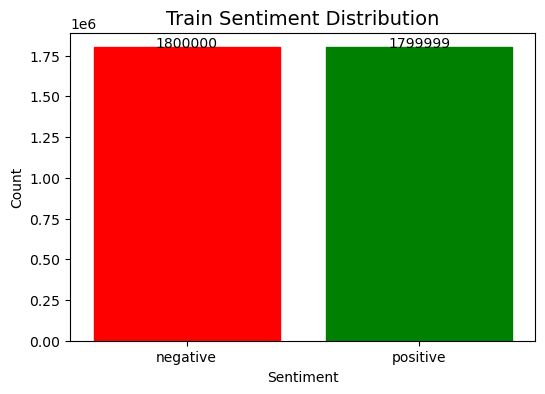

In [13]:
sentiment_counts = train_df['sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['sentiment', 'count']

color_map = {
    'positive': 'green',
    'negative': 'red'
}

plt.figure(figsize=(6, 4))

ax = sns.barplot(
    data=sentiment_counts,
    x='sentiment',
    y='count',
    color=None 
)

for bar, sentiment in zip(ax.patches, sentiment_counts['sentiment']):
    bar.set_color(color_map[sentiment])

# Add text labels
for index, row in sentiment_counts.iterrows():
    plt.text(index, row['count'] + 100, row['count'], ha='center', fontsize=10)

# Labels
plt.title("Train Sentiment Distribution", fontsize=14)
plt.xlabel("Sentiment")
plt.ylabel("Count")

plt.show()

In [14]:
# Create a new column with the number of words in each review
train_df['review_len'] = train_df['clean_text'].apply(lambda x: len(str(x).split()))

# Now you can safely clip the length
review_len_clipped = train_df['review_len'].clip(upper=200)

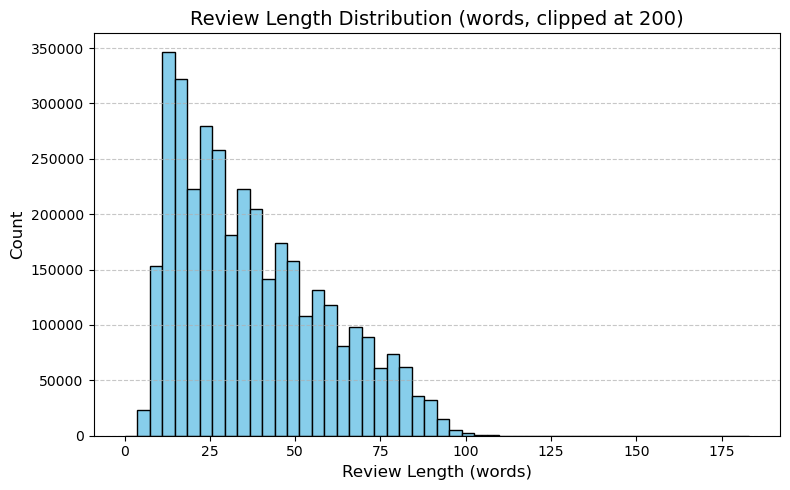

In [15]:
# Clip review length at 200 words
review_len_clipped = train_df['review_len'].clip(upper=200)

# Create histogram using matplotlib
plt.figure(figsize=(8, 5))
plt.hist(
    review_len_clipped,
    bins=50,
    color='skyblue',          
    edgecolor='black',         
    linewidth=1
)

# Add titles and labels
plt.title("Review Length Distribution (words, clipped at 200)", fontsize=14)
plt.xlabel("Review Length (words)", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Grid and layout
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [16]:


neg_text = train_df[train_df['sentiment'] == 'negative']['clean_text']
pos_text = train_df[train_df['sentiment'] == 'positive']['clean_text']

#WordClouds
# neg_text_wc = " ".join(neg_reviews_series)
# pos_text_wc = " ".join(pos_reviews_series)

# plt.figure(figsize=(12,5))

# # Negative WordCloud
# plt.subplot(1,2,1)
# wordcloud_neg = WordCloud(width=600, height=400, background_color='white', max_words=100).generate(neg_text_wc)
# plt.imshow(wordcloud_neg, interpolation='bilinear')
# plt.axis('off')
# plt.title("Negative Reviews WordCloud")

# # Positive WordCloud
# plt.subplot(1,2,2)
# wordcloud_pos = WordCloud(width=600, height=400, background_color='white', max_words=100).generate(pos_text_wc)
# plt.imshow(wordcloud_pos, interpolation='bilinear')
# plt.axis('off')
# plt.title("Positive Reviews WordCloud")
# plt.show()

print("\n--- Top 10 Most Common Words")

# Count words for negative reviews using a generator
neg_words_generator = (word for review in neg_text for word in review.split())
neg_counter = Counter(neg_words_generator)
print("Top 10 negative words:", neg_counter.most_common(10))

# Count words for positive reviews using a generator
pos_words_generator = (word for review in pos_text for word in review.split())
pos_counter = Counter(pos_words_generator)
print("Top 10 positive words:", pos_counter.most_common(10))


--- Top 10 Most Common Words
Top 10 negative words: [('book', 864215), ('one', 646764), ('like', 514071), ('would', 505897), ('get', 373106), ('good', 365287), ('dont', 352863), ('time', 323979), ('even', 306109), ('movie', 286931)]
Top 10 positive words: [('book', 892748), ('one', 607028), ('great', 580954), ('like', 460049), ('good', 453904), ('read', 349243), ('would', 314378), ('love', 302804), ('well', 298973), ('really', 280562)]


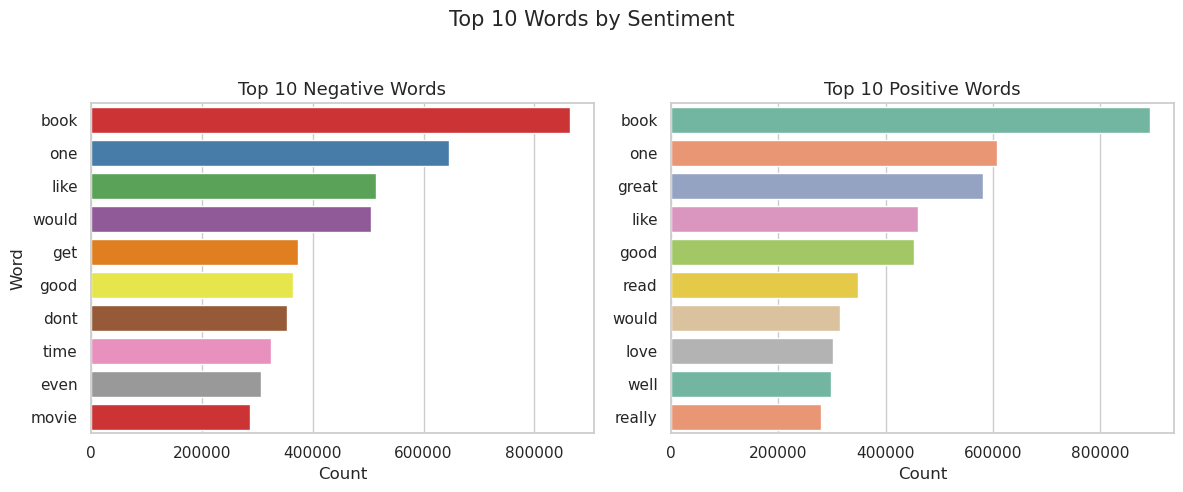

In [17]:
# Get top 10 words for negative and positive sentiment
neg_top10 = pd.DataFrame(neg_counter.most_common(10), columns=['word', 'count'])
pos_top10 = pd.DataFrame(pos_counter.most_common(10), columns=['word', 'count'])

sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Negative Words ---
sns.barplot(
    data=neg_top10,
    x='count',
    y='word',
    hue='word',              
    palette=sns.color_palette("Set1", 10),
    legend=False,            
    ax=axes[0]
)
axes[0].set_title("Top 10 Negative Words", fontsize=13)
axes[0].set_xlabel("Count")
axes[0].set_ylabel("Word")

# --- Positive Words ---
sns.barplot(
    data=pos_top10,
    x='count',
    y='word',
    hue='word',
    palette=sns.color_palette("Set2", 10),
    legend=False,
    ax=axes[1]
)
axes[1].set_title("Top 10 Positive Words", fontsize=13)
axes[1].set_xlabel("Count")
axes[1].set_ylabel("")

plt.suptitle("Top 10 Words by Sentiment", fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [18]:
# Define custom stopwords
custom_stopwords = ['one', 'would', 'get', 'like', 'also', 'us', 'book', 'time', 'even', 'movie', 'good', 'read']
stop_words_extended = stop_words.union(custom_stopwords)

def remove_custom_stopwords(text):
    return " ".join([word for word in text.split() if word not in stop_words_extended])

# Apply to train dataset
train_df['clean_text_final'] = train_df['clean_text'].apply(remove_custom_stopwords)
test_df['clean_text_final'] = test_df['clean_text'].apply(remove_custom_stopwords)

# Combine cleaned text per class
neg_text_final = " ".join(train_df[train_df['sentiment']=='negative']['clean_text_final'])
pos_text_final = " ".join(train_df[train_df['sentiment']=='positive']['clean_text_final'])

# Count words
neg_counter_final = Counter(neg_text_final.split())
pos_counter_final = Counter(pos_text_final.split())

# Display top 10 words after custom stopwords removal
print("Top 10 negative words (custom stopwords removed):", neg_counter_final.most_common(10))
print("Top 10 positive words (custom stopwords removed):", pos_counter_final.most_common(10))

Top 10 negative words (custom stopwords removed): [('dont', 352863), ('really', 265202), ('much', 261877), ('product', 246628), ('first', 246281), ('buy', 240019), ('money', 221904), ('bought', 216934), ('better', 215031), ('could', 212122)]
Top 10 positive words (custom stopwords removed): [('great', 580954), ('love', 302804), ('well', 298973), ('really', 280562), ('best', 232962), ('first', 227166), ('much', 215267), ('cd', 210925), ('album', 203852), ('dont', 195413)]


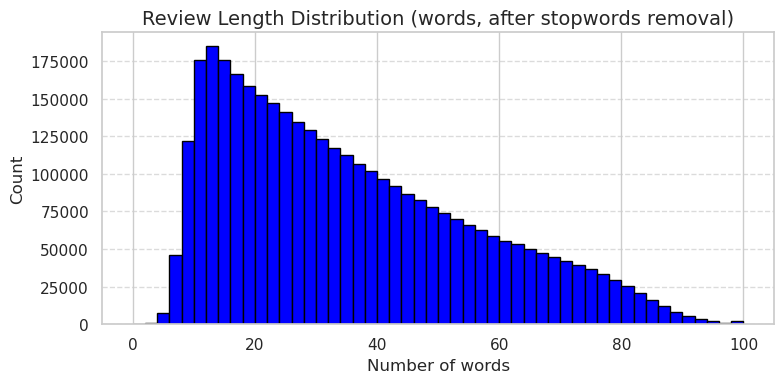

In [19]:
# Compute review length if not already
train_df['review_len_final'] = train_df['clean_text_final'].apply(lambda x: len(x.split()))

# Clip review length at 100 words
review_len_clipped = train_df['review_len_final'].clip(upper=100)

# --- Matplotlib Histogram ---
plt.figure(figsize=(8, 4))
plt.hist(
    review_len_clipped,
    bins=50,
    color='blue',          
    edgecolor='black',    
    linewidth=1
)

# Add title and labels
plt.title("Review Length Distribution (words, after stopwords removal)", fontsize=14)
plt.xlabel("Number of words", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Grid and layout
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
#take a subset from the original dataset
TRAIN_SIZE = min(100000, len(train_df))
TEST_SIZE  = min(100000, len(test_df))

train_subset = train_df.sample(n=TRAIN_SIZE, random_state=42)
test_subset  = test_df.sample(n=TEST_SIZE, random_state=42)

tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1, 2), min_df=3, max_df=0.9, sublinear_tf=True)
X_train_sub = tfidf.fit_transform(train_subset['clean_text_final'])
X_test_sub = tfidf.transform(test_subset['clean_text_final'])

# Labels
y_train_sub = train_subset['sentiment'].map({'negative':0, 'positive':1}).values
y_test_sub = test_subset['sentiment'].map({'negative':0, 'positive':1}).values

# Check shapes
print("X_train_sub shape:", X_train_sub.shape)
print("X_test_sub shape:", X_test_sub.shape)

X_train_sub shape: (100000, 20000)
X_test_sub shape: (100000, 20000)


In [21]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    pred_time = time.time() - start_time

    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "Prediction Time (s)": pred_time
    }
    return y_pred, metrics

In [22]:
# Models to evaluate
models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Naive Bayes": MultinomialNB(),
    "SVM": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBClassifier(eval_metric='logloss', random_state=42)
}

results = {}

# Track best model
best_model = None
best_model_name = None
best_score = -1

# Train, predict, evaluate
for name, model in models.items():
    print(f"Training {name} ...")
    y_pred, metrics = evaluate_model(model, X_train_sub, y_train_sub, X_test_sub, y_test_sub)
    results[name] = metrics

    if metrics["F1-Score"] > best_score:
        best_score = metrics["F1-Score"]
        best_model = model
        best_model_name = name

# Save results
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by="F1-Score", ascending=False)

print("\nAll Model Metrics & Time Comparison on Subset:")
print(results_df)

print(f"\nBest Model: {best_model_name} (F1-Score = {best_score:.4f})")

Training Logistic Regression ...
Training Naive Bayes ...
Training SVM ...
Training Random Forest ...
Training XGBoost ...

All Model Metrics & Time Comparison on Subset:
                     Accuracy  Precision    Recall  F1-Score  \
Logistic Regression   0.86909   0.866335  0.872186  0.869251   
SVM                   0.86315   0.860724  0.865813  0.863261   
Naive Bayes           0.84391   0.842279  0.845469  0.843871   
Random Forest         0.83156   0.842172  0.815164  0.828448   
XGBoost               0.82317   0.811497  0.840920  0.825946   

                     Prediction Time (s)  
Logistic Regression             0.650621  
SVM                             2.034595  
Naive Bayes                     0.058686  
Random Forest                 387.232937  
XGBoost                        34.468295  

Best Model: Logistic Regression (F1-Score = 0.8693)


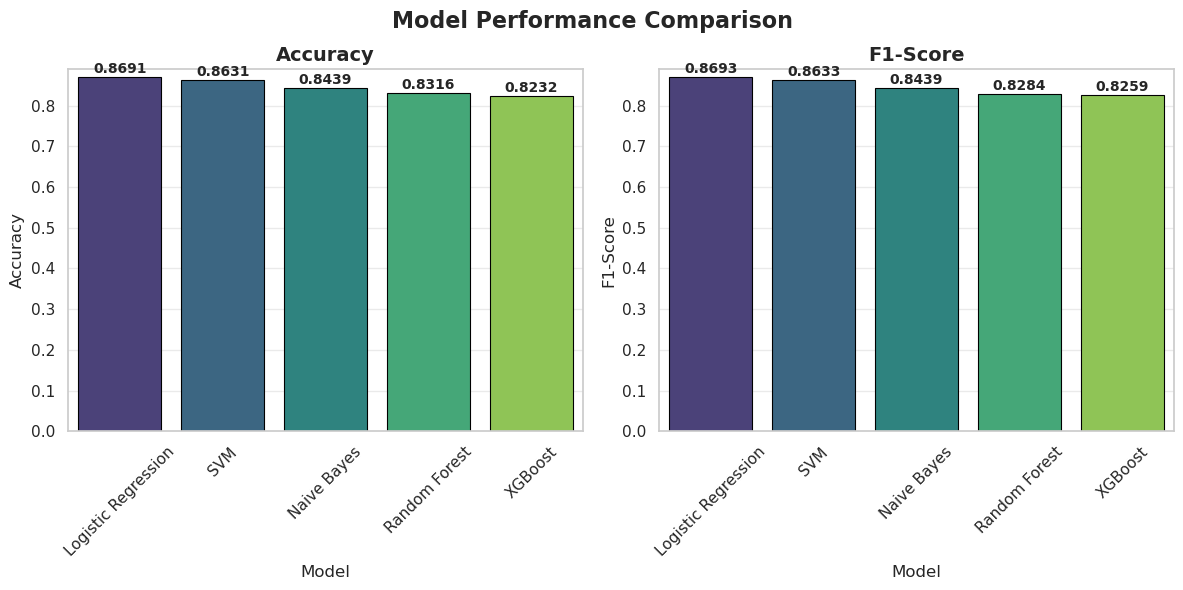

In [23]:
# Style
sns.set_style("whitegrid")

metrics_to_plot = ["Accuracy", "F1-Score"]

plot_df = results_df.copy()
plot_df["Model"] = plot_df.index

colors = sns.color_palette("viridis", len(plot_df))

plt.figure(figsize=(12, 6))

for i, metric in enumerate(metrics_to_plot, 1):

    plt.subplot(1, len(metrics_to_plot), i)

    sns.barplot(
        x=plot_df["Model"], 
        y=plot_df[metric],
        hue=plot_df["Model"],      
        palette=colors,
        legend=False,
        edgecolor='black',
        linewidth=0.8
    )

    for idx, val in enumerate(plot_df[metric]):
        plt.text(
            idx, val + 0.01, 
            f"{val:.4f}",
            ha='center', fontsize=10, fontweight='bold'
        )

    plt.title(f"{metric}", fontsize=14, fontweight="bold")
    plt.xlabel("Model", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.xticks(rotation=45)

    upper = plot_df[metric].max() + 0.02
    plt.ylim(0, upper)

    plt.grid(axis='y', linestyle='-', alpha=0.4)
    plt.grid(axis='x', visible=False)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle(
    "Model Performance Comparison",
    fontsize=16, fontweight="bold"
)

plt.show()

In [24]:
joblib.dump(best_model, "best_model.pkl")     
joblib.dump(tfidf, "tfidf_vectorizer.pkl")    

print(f"Best model '{best_model_name}' saved successfully!")
print("TF-IDF vectorizer saved successfully!")

Best model 'Logistic Regression' saved successfully!
TF-IDF vectorizer saved successfully!


In [25]:
# Display DataFrame
print("Model Performance Overview:")

# Create DataFrame for comparison
results_df = pd.DataFrame(results).T  # transpose for readability
results_df = results_df.sort_values(by="Accuracy", ascending=False)  

# Display nicely in notebook
results_df.style.background_gradient(cmap='Blues')

Model Performance Overview:


,Accuracy,Precision,Recall,F1-Score,Prediction Time (s)
Logistic Regression,0.869090,0.866335,0.872186,0.869251,0.650621
SVM,0.863150,0.860724,0.865813,0.863261,2.034595
Naive Bayes,0.843910,0.842279,0.845469,0.843871,0.058686
Random Forest,0.831560,0.842172,0.815164,0.828448,387.232937
XGBoost,0.823170,0.811497,0.840920,0.825946,34.468295


In [26]:
# ------------------------------------------------------
# Step 2: Load saved model and vectorizer
# ------------------------------------------------------
model = joblib.load("best_model.pkl")
vectorizer = joblib.load("tfidf_vectorizer.pkl")

print("Model and vectorizer loaded successfully!\n")

Model and vectorizer loaded successfully!



In [27]:
data = {
    "review": [
        # Positive
        "I love this product, it works great!",
        "Amazing quality and super fast delivery.",
        "Highly recommend, I'm very satisfied.",
        "Best purchase ever! Worth every penny.",
        "Excellent service and friendly staff.",
        "I'm so happy with my order, thank you!",
        "The design is beautiful and feels premium.",
        "Five stars! Would definitely buy again.",
        "Great experience overall, no issues at all.",
        "Perfect size, color, and quality!",
        "Really good, it exceeded my expectations.",
        "Totally worth it, great value for money.",
        "Everything arrived on time, thank you!",
        "Love it so much, very comfortable to use.",
        "Fast delivery and great customer support.",
        "Exactly what I needed, works perfectly.",
        "Very nice product, looks amazing.",
        "Satisfied with my purchase, thank you!",
        "Super easy to use and setup.",
        "Absolutely fantastic experience!",
        # Negative
        "Terrible quality, broke after one use.",
        "Waste of money, very disappointed.",
        "Worst purchase I've made online.",
        "Item arrived damaged and dirty.",
        "Customer support was not helpful at all.",
        "Didn't work as described, useless.",
        "The color was different from the pictures.",
        "Late delivery and poor packaging.",
        "I don't recommend this to anyone.",
        "Not worth the price, too expensive.",
        "Bad quality and weird smell.",
        "Completely stopped working after two days.",
        "Cheap material, looks nothing like the image.",
        "Disappointed, expected much better.",
        "Wouldn't buy again, not satisfied.",
        "Horrible experience, waste of time.",
        "Very slow delivery, bad service.",
        "Feels cheap and fragile.",
        "Item was missing parts.",
        "Worst experience ever!"
    ],
    "label": [
        1, 1, 1, 1, 1,
        1, 1, 1, 1, 1,
        1, 1, 1, 1, 1,
        1, 1, 1, 1, 1,
        0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,
        0, 0, 0, 0, 0
    ]
}

df_unseen = pd.DataFrame(data)
df_unseen.sample(6)

,review,label
25,"Didn't work as described, useless.",0
36,"Very slow delivery, bad service.",0
21,"Waste of money, very disappointed.",0
9,"Perfect size, color, and quality!",1
35,"Horrible experience, waste of time.",0
32,"Cheap material, looks nothing like the image.",0


In [28]:
X_unseen = vectorizer.transform(df_unseen['review'])
y_true = df_unseen['label']

# ------------------------------------------------------
# Step 5: Predict with the loaded model
# ------------------------------------------------------
y_pred = model.predict(X_unseen)

# ------------------------------------------------------
# Step 6: Evaluate model performance
# ------------------------------------------------------
print("📊 Model Performance on Unseen Dataset:")
print(f"Accuracy:  {accuracy_score(y_true, y_pred):.2f}")
print(f"Precision: {precision_score(y_true, y_pred):.2f}")
print(f"Recall:    {recall_score(y_true, y_pred):.2f}")
print(f"F1-Score:  {f1_score(y_true, y_pred):.2f}\n")

print("📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

# ------------------------------------------------------
# Step 7: Optional — Show some predictions
# ------------------------------------------------------
print("\n🔍 Example Predictions:")
for i in range(5):
    print(f"Review: {df_unseen['review'][i]}")
    print(f"Predicted Sentiment: {'Positive' if y_pred[i] == 1 else 'Negative'} | Actual: {'Positive' if y_true[i] == 1 else 'Negative'}\n")

📊 Model Performance on Unseen Dataset:
Accuracy:  0.93
Precision: 0.87
Recall:    1.00
F1-Score:  0.93

📋 Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      0.85      0.92        20
    Positive       0.87      1.00      0.93        20

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.93      0.93      0.92        40


🔍 Example Predictions:
Review: I love this product, it works great!
Predicted Sentiment: Positive | Actual: Positive

Review: Amazing quality and super fast delivery.
Predicted Sentiment: Positive | Actual: Positive

Review: Highly recommend, I'm very satisfied.
Predicted Sentiment: Positive | Actual: Positive

Review: Best purchase ever! Worth every penny.
Predicted Sentiment: Positive | Actual: Positive

Review: Excellent service and friendly staff.
Predicted Sentiment: Positive | Actual: Positive

